# RetailPulse: RFM Customer Segmentation

RFM (Recency, Frequency, Monetary) analysis is a powerful customer segmentation technique often used in marketing. It categorizes customers based on their purchasing history and can be very effective in a retail context. To conduct an RFM analysis for a global retail company, we'll follow these steps using Python:

1. Data Preparation
Data Collection: Ensure you have customer transaction data including customer IDs, order dates, and purchase amounts.
Data Cleaning: Clean the dataset for any missing values or outliers that might skew the analysis.
2. Calculating RFM Metrics
Recency (R): Time since last purchase. Calculate the number of days since the last purchase for each customer.
Frequency (F): Total number of purchases. Count the number of purchases for each customer.
Monetary (M): Total money spent. Calculate the total amount spent by each customer.
3. Assigning RFM Scores
Scoring: Assign a score (typically 1-5) for each RFM metric for each customer. A common approach is to use quintiles (dividing into five equal parts) where '5' is the best score.
RFM Score Calculation: Combine the individual R, F, and M scores into a single score (e.g., 555, 543).
4. Segmenting Customers
Segment Definition: Define segments based on RFM scores, such as "Best Customers" (high R, F, and M), "Loyal Customers" (high F), "Big Spenders" (high M), "At Risk" (high M but low R), etc.
Segment Analysis: Analyze the characteristics and behavior of each segment.
5. Implementing Targeted Strategies
Marketing Strategies: Develop targeted strategies for each segment. For instance, "Best Customers" might receive exclusive offers, while "At Risk" customers might be targeted with re-engagement campaigns.
6. Monitoring and Optimization
Performance Tracking: Continuously monitor the performance of segmentation strategies.
Adjustment: Adjust strategies based on customer responses and changing patterns.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import json
import geopandas as gpd
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.models import HoverTool
import warnings
warnings.filterwarnings('ignore', category=UserWarning)



# Python Libraries for Data Analysis and Visualization

1. Pandas (pandas)
Data manipulation library that provides data structures like DataFrame for easy data analysis.
2. NumPy (numpy)
Essential for scientific computing in Python, NumPy offers support for large, multi-dimensional arrays and matrices, along with a large collection of mathematical functions to operate on these arrays.
3. Datetime (datetime)
This module supplies classes for manipulating dates and times in both simple and complex ways.
4. Matplotlib (matplotlib.pyplot)
A plotting library which is very useful for creating static, interactive, and animated visualizations in Python.
5. Seaborn (seaborn)
Based on matplotlib, seaborn provides a high-level interface for drawing attractive and informative statistical graphics.
6. Squarify (squarify)
This module helps to plot tree maps, which can visualize hierarchical data structures.
7. JSON (json)
Used for parsing and manipulating data in JSON format, a common data format used for storage and data exchange.
8. GeoPandas (geopandas)
An open-source project to make working with geospatial data in Python easier. It extends the datatypes used by pandas to allow spatial operations on geometric types.
9. Bokeh (bokeh)
A Python interactive visualization library that targets modern web browsers for presentation, providing elegant, concise construction of versatile graphics, and affords high-performance interactivity over large or streaming datasets.

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
df = pd.read_csv('data/superstore_dataset.csv', encoding='cp1252')
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df = df.drop(['row_id', 'ship_date', 'customer_name', 'postal_code', 'shipping_cost', 'order_priority'], axis=1)
df['order_date'] = pd.to_datetime(df['order_date'])
today = datetime.strptime('2015-01-31', '%Y-%m-%d')

## Dataset overview

The retail dataset of a global superstore for years 2011-2015 is used in this analysis. It contains information about:
* order, order date, ship mode
* ordered products, their category
* customer, type of customer, location
* sales, quantity, profit, discount

Number of records in the dataset: 51,290

In [3]:
df.head()

,order_id,order_date,ship_mode,customer_id,segment,city,state,country,market,region,product_id,category,sub-category,product_name,sales,quantity,discount,profit
0,AG-2011-2040,2011-01-01,Standard Class,TB-11280,Consumer,Constantine,Constantine,Algeria,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.30,2,0.00,106.14
1,IN-2011-47883,2011-01-01,Standard Class,JH-15985,Consumer,Wagga Wagga,New South Wales,Australia,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.37,3,0.10,36.04
2,HU-2011-1220,2011-01-01,Second Class,AT-735,Consumer,Budapest,Budapest,Hungary,EMEA,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.12,4,0.00,29.64
3,IT-2011-3647632,2011-01-01,Second Class,EM-14140,Home Office,Stockholm,Stockholm,Sweden,EU,North,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.87,3,0.50,-26.05
4,IN-2011-47883,2011-01-01,Standard Class,JH-15985,Consumer,Wagga Wagga,New South Wales,Australia,APAC,Oceania,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.67,5,0.10,37.77


In [4]:
agg_dict1 = {
    'order_id': 'count',
    'order_date': 'max',
    'sales': 'sum'
}
df_rfm = df.groupby('customer_id').agg(agg_dict1).reset_index()
df_rfm.columns = ['customer_id', 'frequency', 'max_date', 'monetary']
df_rfm['recency'] = (today - df_rfm['max_date']).dt.days
df_rfm.drop(['max_date'], axis=1, inplace=True)

## Recency, Frequency, Monetary

RFM model combines three different customer attributes to rank customers:
* **Recency (R)**: Who have purchased recently? Number of days since last purchase
* **Frequency (F)**: Who has purchased frequently? The total number of purchases
* **Monetary Value(M)**: Who has high purchase amount? The total money customer spent

If the customer bought in recent past, he gets higher points. If he bought many times, he gets higher score. And if he spent a lot of money, he gets more points.

How to create segments?
* Concatenate all scores into one, eg: 3-4-1 (R-F-M) and group customers according to those values. It gives 125 combinations which is difficult to depict and understand
* Sum all scores into one, eg: 8 (3 + 4 + 1) and group customers according to this number. It creates 13 groups which is much easier to work with but it disregards relations between R & F & M
* Segment customers based on set of rules applied to R-F-M scores. It creates 10 groups, such as "champions", "needing attention" or "at risk"

In [5]:
r_labels = range(5, 0, -1)  # Higher score for more recent purchases
f_labels = range(1, 6)
m_labels = range(1, 6)

df_rfm['r_score'] = pd.qcut(df_rfm['recency'], q=5, labels=r_labels).astype(int)
df_rfm['f_score'] = pd.qcut(df_rfm['frequency'], q=5, labels=f_labels).astype(int)
df_rfm['m_score'] = pd.qcut(df_rfm['monetary'], q=5, labels=m_labels).astype(int)

df_rfm['rfm_sum'] = df_rfm['r_score'] + df_rfm['f_score'] + df_rfm['m_score']

In [6]:
def assign_label(df, r_rule, fm_rule, label, colname='rfm_label'):
    df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
            & (df['f_score'].between(fm_rule[0], fm_rule[1])), colname] = label
    return df

In [7]:
df_rfm['rfm_label'] = ''

df_rfm = assign_label(df_rfm, (5,5), (4,5), 'champions')
df_rfm = assign_label(df_rfm, (3,4), (4,5), 'loyal customers')
df_rfm = assign_label(df_rfm, (4,5), (2,3), 'potential loyalist')
df_rfm = assign_label(df_rfm, (5,5), (1,1), 'new customers')
df_rfm = assign_label(df_rfm, (4,4), (1,1), 'promising')
df_rfm = assign_label(df_rfm, (3,3), (3,3), 'needing attention')
df_rfm = assign_label(df_rfm, (3,3), (1,2), 'about to sleep')
df_rfm = assign_label(df_rfm, (1,2), (3,4), 'at risk')
df_rfm = assign_label(df_rfm, (1,2), (5,5), 'cant loose them')
df_rfm = assign_label(df_rfm, (1,2), (1,2), 'hibernating')

## RFM Customer Segments

* **Champions** - bought recently, buy often and spend the most
* **Loyal Customers** - spend good money and often, responsive to promotions
* **Potential Loyalist** - recent customers, but spent a good amount and bought more than once
* **New Customers** - bought most recently, but not often
* **Promising** - recent shoppers, but haven’t spent much
* **Needing Attention** - above average recency, frequency and monetary values; may not have bought very recently though
* **About To Sleep** - below average recency, frequency and monetary values; will lose them if not reactivated
* **At Risk** - spent big money and purchased often but long time ago; need to bring them back
* **Can't Loose Them** - made biggest purchases, and often but haven’t returned for a long time
* **Hibernating** - last purchase was long back, low spenders and low number of orders

## Distribution of Recency, Frequency and Monetary

Recency distribution is right-skewed, showing that the majority of customers made a purchase in the recent past. It has a long tail containing single customers who made their order long time ago.

Both frequency and monetary distributions are bimodal (with two different peaks - modes). The chart reveals that one group of customers has low frequency (small number of orders, around 10 per customer) and another group is much more "loyal" (with around 50 purchases per customer). When it comes to monetary, it follows similar pattern. Part of customers have only spent little amount of money but there is another (significant in size) group that have spent much more.

Frequency and monetary distributions suggest that there are visible differences between different groups of customers. By looking at the distribution of three the biggest segments: "loyal customers", "hibernating", "potential loyalist" it's easy to see that indeed they build up different parts of total distribution, eg. hibernating customers are responsible for first monetary peak and loyal customers for the second peak.

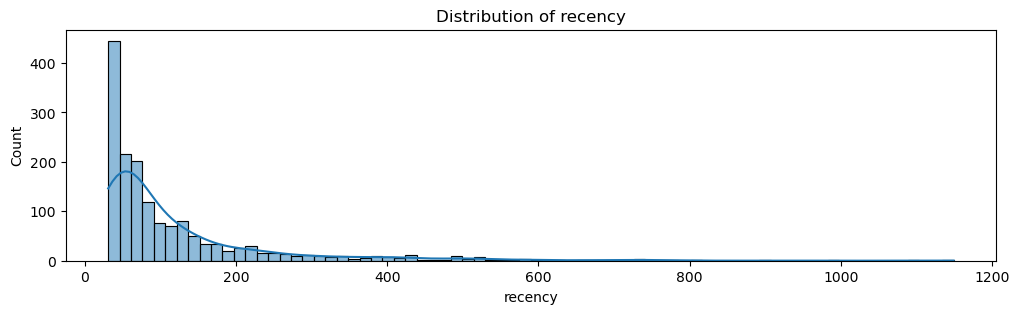

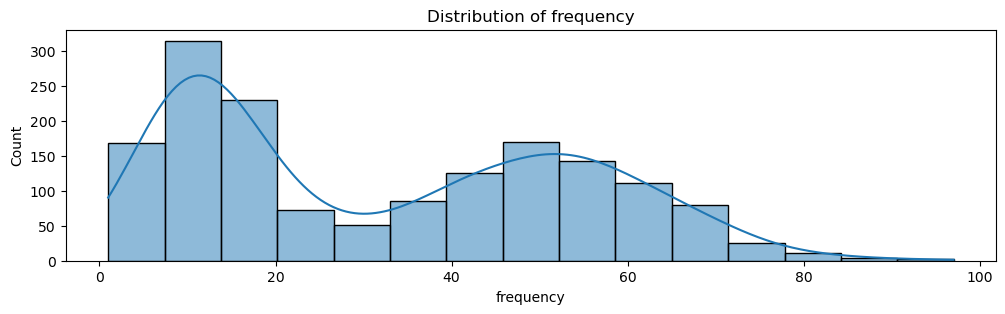

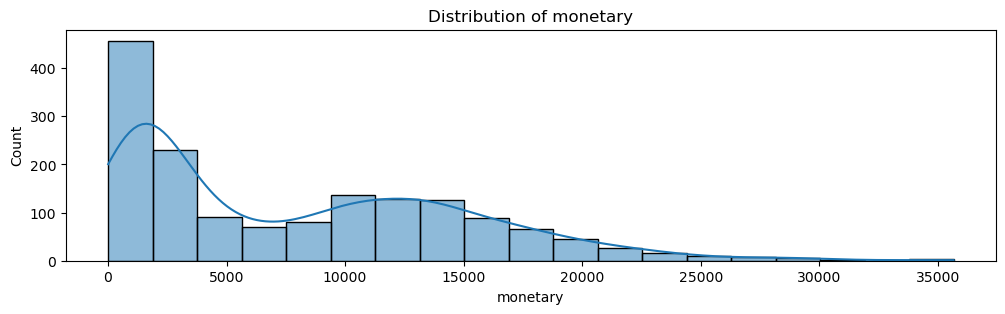

In [8]:
colnames = ['recency', 'frequency', 'monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.histplot(df_rfm[col], kde=True, ax=ax)
    ax.set_title('Distribution of %s' % col)
    plt.show()

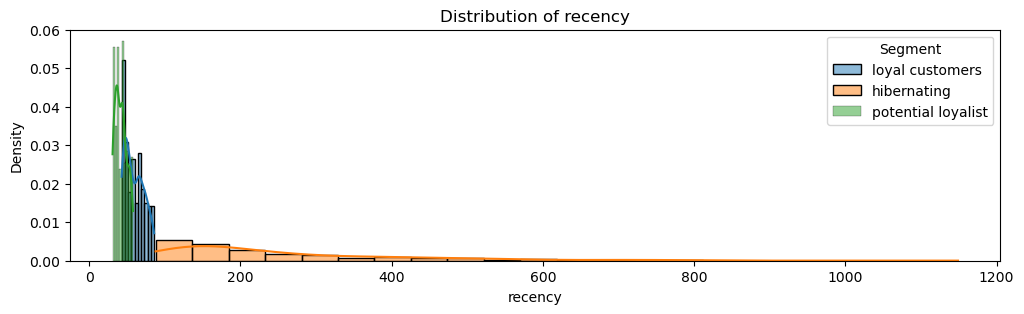

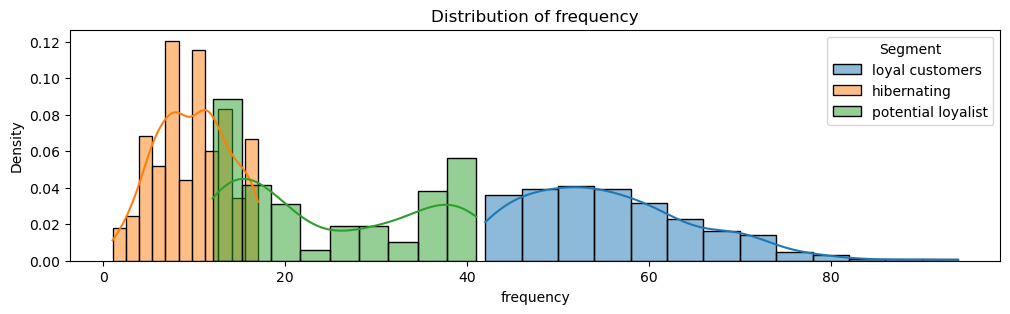

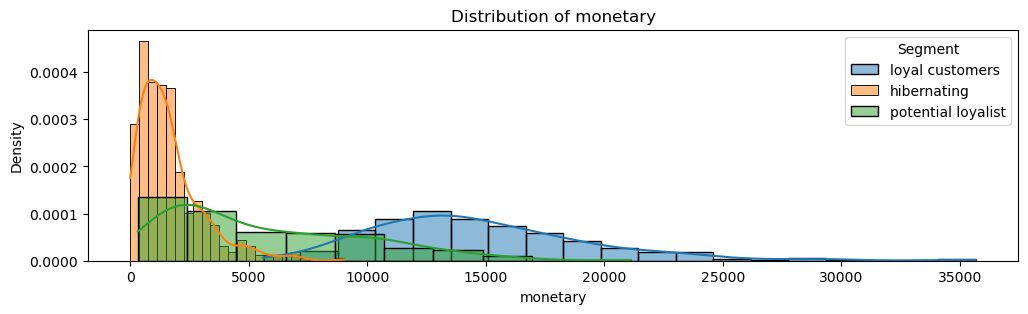

In [9]:
segments = ['loyal customers', 'hibernating', 'potential loyalist']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    for segment in segments:
        sns.histplot(
            df_rfm[df_rfm['rfm_label'] == segment][col],
            kde=True,
            stat='density',  # This will plot the density on the y-axis
            label=segment,
            ax=ax
        )
    ax.set_title('Distribution of %s' % col)
    ax.legend(title='Segment')
    plt.show()

## Analysis of RFM Segments

Analysis of clusters obtained by summing up RFM scores shows that their sizes are quite similar. There is a peak around score = 12 which shows that the group of customers from segments 11-13 is numerous - those are the customers that generate stable, significant income. The smallest segment is for RFM score = 15 - it's understandable cause those are the most valuable gems in the customer base. Although it's the smallest group, it is still quite big in size.

Analysis of clusters based on set of rules applied to R-F-M scores is much more diverse. It's good to see that 'loyal customers' and 'potential loyalists' constitute around 1/3 of all customers (generating almost 1/2 of sales). What is more, there is strong group of 'champions' who are the most profitable customers (13% of all customers generating 25% of all sales). At the same time it should worry that group of 'hibernating' is so big - over 1/4 of all customers. There is an opportunity that part of this group could be reactivated with a reach out campaign. Moreover, the company should focus on the group 'at risk' to increase customer retention (they generate 10% of total sales).

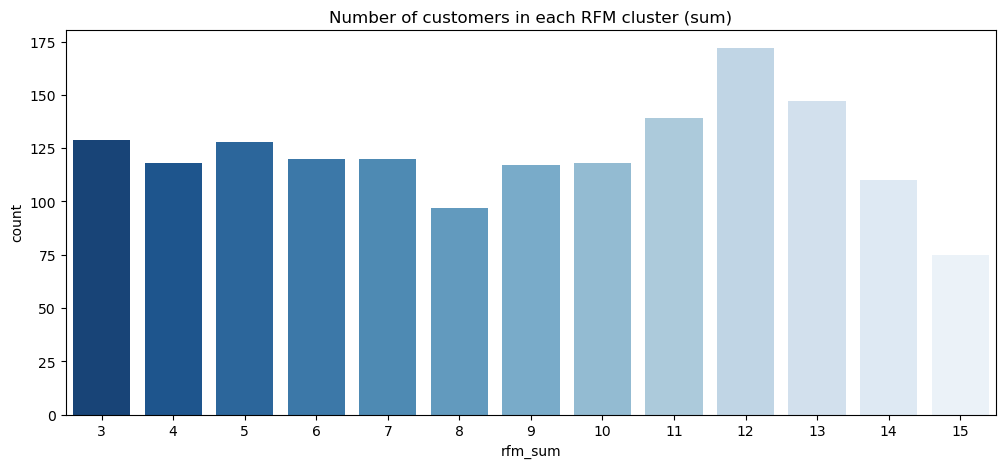

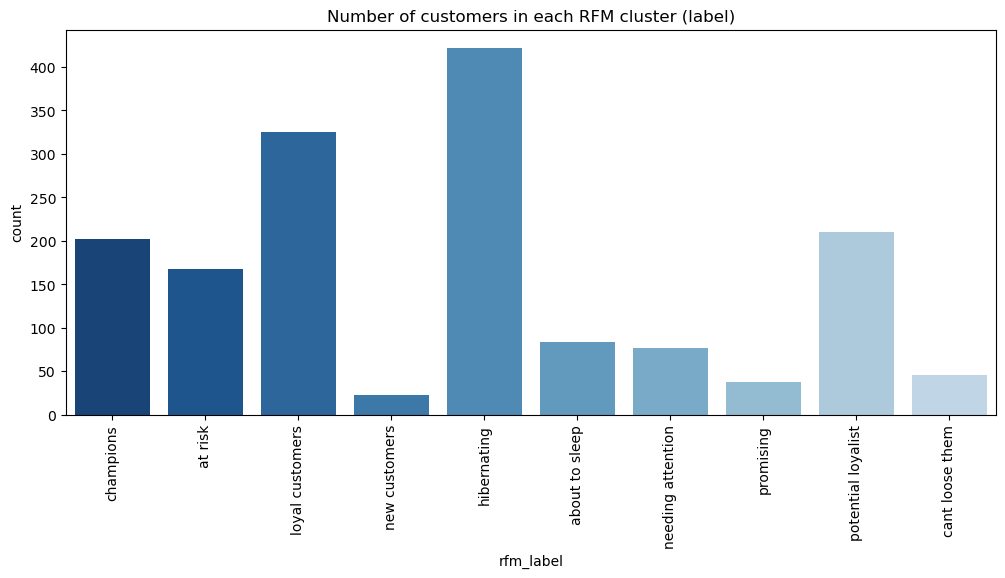

In [10]:
palette = sns.color_palette("Blues_r", n_colors=13)

for rfm_type in ['sum', 'label']:
    fig, ax = plt.subplots(figsize=(12,5))
    sns.countplot(x='rfm_'+rfm_type, data=df_rfm, palette=palette)
    ax.set_title('Number of customers in each RFM cluster (%s)' % rfm_type)
    if rfm_type == 'label':
        plt.xticks(rotation=90)
    plt.show()

In [11]:
agg_dict2 = {
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'sum'
}

df_analysis = df_rfm.groupby('rfm_label').agg(agg_dict2).sort_values(by='recency').reset_index()
df_analysis.rename({'rfm_label': 'label', 'customer_id': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['monetary_share'] = df_analysis['monetary'] / df_analysis['monetary'].sum()
df_analysis['monetary'] = df_analysis['monetary'] / df_analysis['count']

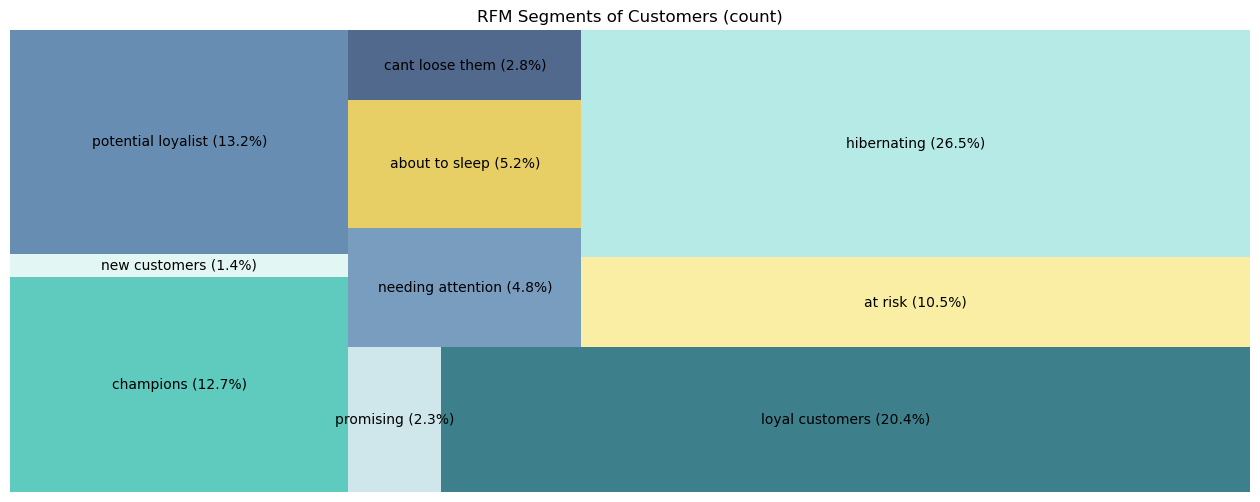

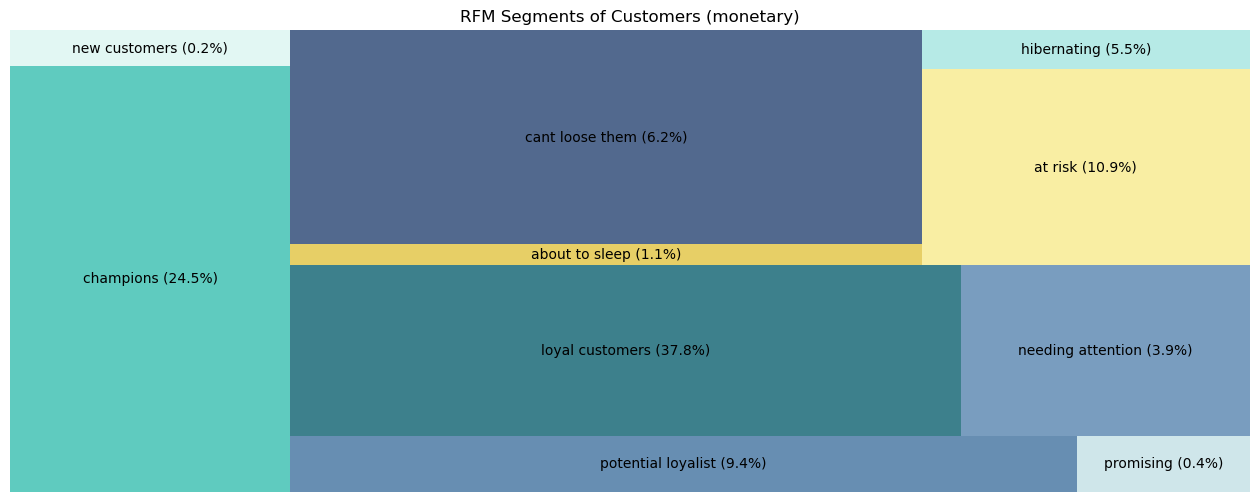

In [12]:
colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['count', 'monetary']:
    labels = df_analysis['label'] + df_analysis[col + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()

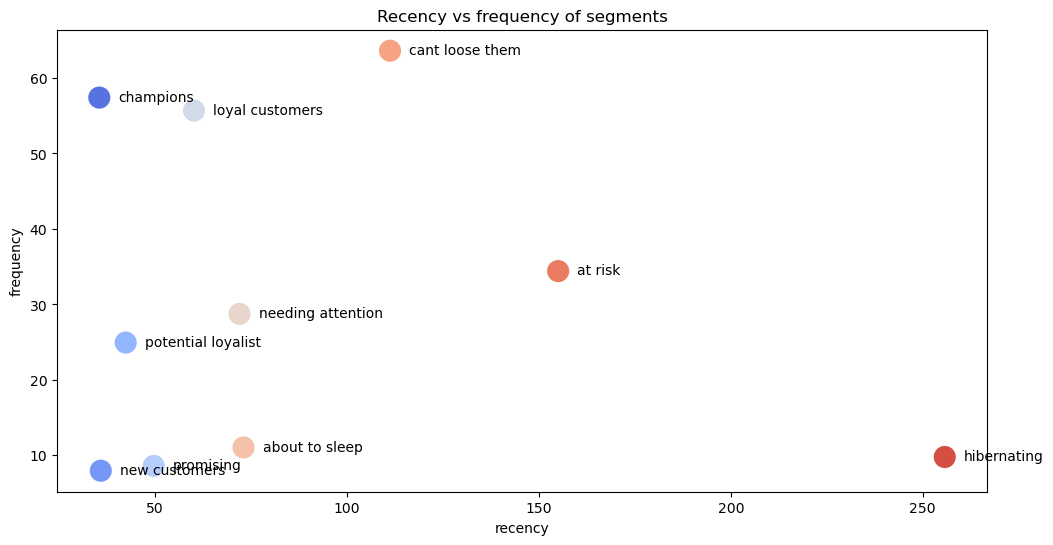

In [13]:
palette = sns.color_palette("coolwarm", 10)

fig, ax = plt.subplots(figsize=(12,6))
plot = sns.scatterplot(x='recency', y='frequency', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['recency'][i]+5,
               df_analysis['frequency'][i]-0.5,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs frequency of segments')
ax.get_legend().remove()
plt.show()

As expected, scatterplot visualizes the set of rules applied to generate RFM segments. 'Champions' and 'loyal customers' are the ones who buy the most often and who made their last order recently. 'New customers' and 'promising' made purchases not long time ago but they are not frequent buyers yet. And 'hibernating' customers are the ones with the lowest recency and frequency scores.

## Demographic Analysis of RFM segments

The dataset contains information about orders placed by customers from all over the world. Analysis of customer's country of origing combained with RFM score gives an interesting overview of the most profitable locations.

United States is the market not only responsible for the biggest share of all orders but also with high RFM score. Other locations with good-quality customers are: Latin America, Western Europe, South-East Asia and Australia.

In [14]:
df = df.merge(df_rfm[['customer_id', 'rfm_sum', 'rfm_label']], on='customer_id', how='left')

In [15]:
country_dict = {
    "United States": "United States of America",
    "Singapore": "Malaysia",
    "Tanzania": "United Republic of Tanzania",
    "Myanmar (Burma)": "Myanmar",
    "Cote d'Ivoire": "Ivory Coast",
    "Czech Republic": "Czechia",
    "Martinique": "France",
    "Guadeloupe": "France",
    "Hong Kong": "China",
    "Swaziland": "eSwatini",
}

df['country'] = df['country'].apply(lambda x: country_dict[x] if x in country_dict.keys() else x)

In [16]:
agg_dict3 = {
    'order_id': 'nunique',
    'rfm_sum': 'mean'
}
df_country = df.groupby('country').agg(agg_dict3).reset_index().rename({'order_id': 'orders_count'}, axis=1)

In [17]:
shapefile = 'data/countries_110m/ne_110m_admin_0_countries.shp'
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf = gdf.drop(gdf.index[159])

In [18]:
gdf_rfm = gdf.merge(df_country, on='country', how='left')

gdf_rfm_json = json.loads(gdf_rfm.to_json())
json_data = json.dumps(gdf_rfm_json)

In [19]:
geosource = GeoJSONDataSource(geojson = json_data)
palette = brewer['YlGnBu'][8]
palette = palette[::-1]

color_mapper = LinearColorMapper(palette = palette, low = 0, high = 14, nan_color = '#d9d9d9')
color_bar = ColorBar(color_mapper=color_mapper,
                     label_standoff=8,
                     width = 500,
                     height = 20,
                     border_line_color=None,
                     location = (0,0),
                     orientation = 'horizontal')

hover = HoverTool(tooltips = [ ('Country','@country'),('RFM score', '@rfm_sum'), ('Number of orders', '@orders_count')])

p = figure(title = 'RFM score by country', height = 600 , width = 950, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

p.patches('xs','ys', source = geosource,fill_color = {'field' :'rfm_sum', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
p.add_layout(color_bar, 'below')

output_notebook()
show(p)

Loading BokehJS ...

## Behavioral Analysis of RFM Segments

In this part, let's examine customers' transaction history. Quantity of products in order and sales are highly correlated with each other (linear relationship) - groups of custmers who place orders with numerous products generate big sales at the same time. It implies that average price of one product is similar between segments.

Segments generating the highest sales are: 'can't loose them', 'loyal customers' and 'champions'. They also have high RFM score (dark purple color of a marker) and they are responsible for the highest profit (the biggest size of a marker).

In [20]:
agg_dict4 = {
    'product_id': 'count',
    'quantity': 'sum',
    'sales': 'sum',
    'discount': 'sum',
    'profit': 'sum',
    'rfm_sum': 'first',
    'rfm_label': 'first'
}

df_order = df.groupby('order_id').agg(agg_dict4).reset_index()
df_order_segment = df_order.groupby('rfm_label')[['quantity', 'sales', 'discount', 'profit', 'rfm_sum']].mean().reset_index()

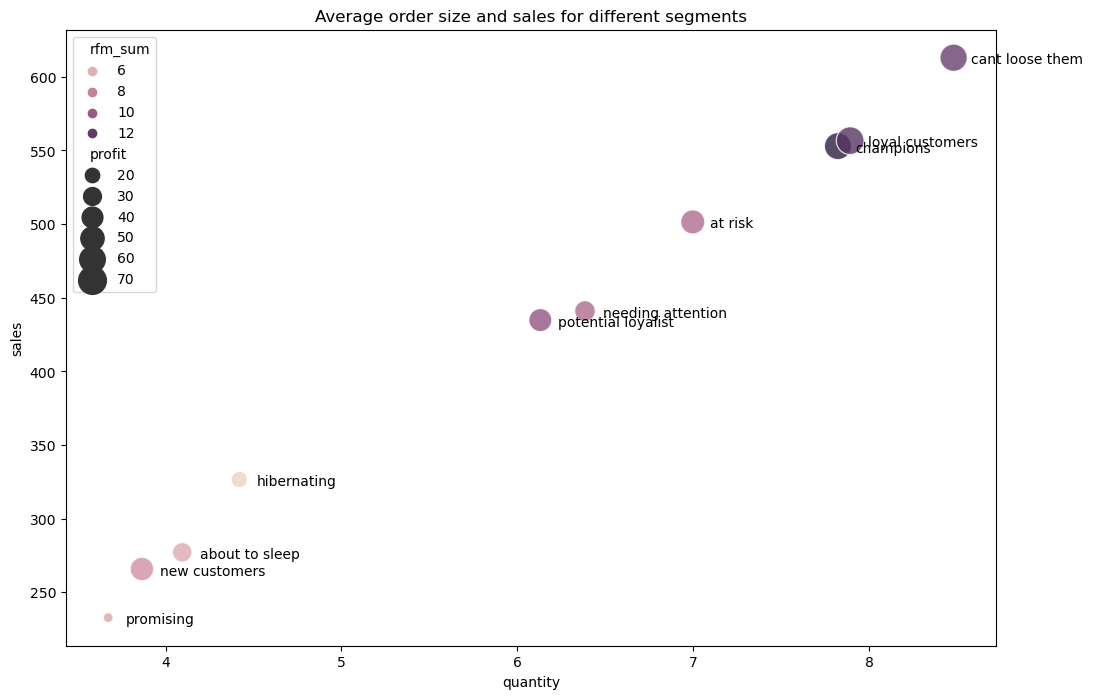

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
plot = sns.scatterplot(x='quantity', y='sales', data=df_order_segment, size='profit', sizes=(50,400), hue='rfm_sum', alpha=.8)

for i in range(len(df_order_segment)):
     plot.text(df_order_segment['quantity'][i]+0.1,
               df_order_segment['sales'][i]-4,
               df_order_segment['rfm_label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Average order size and sales for different segments')
plt.show()

### Reference

1. https://www.putler.com/rfm-analysis/
2. https://clevertap.com/blog/rfm-analysis/
3. https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17
4. https://www.datacamp.com/community/tutorials/introduction-customer-segmentation-python
5. https://www.r-bloggers.com/rfm-analysis-in-r/
6. https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

Dataset: https://www.kaggle.com/jr2ngb/superstore-data